In [1]:
import numpy as np
import cvxpy as cp
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cvxpy import SolverError

## Problem 3 Separable

In [2]:
data_train = scipy.io.loadmat("separable_case/train_separable.mat")
data_test = scipy.io.loadmat("separable_case/test_separable.mat")

In [3]:
A = data_train["A"]
B = data_train["B"]

test = data_test["X_test"]
test_label = data_test["true_labels"].ravel()

In [4]:
np.random.seed(42)

In [5]:
z_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))
m_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))

In [10]:
x1_0 = z_0
x2_0 = np.matmul(A, z_0)
x3_0 = m_0
x4_0 = np.matmul(B, m_0)

x1_prev = x1_0
x2_prev = x2_0
x3_prev = x3_0
x4_prev = x4_0

u1_0 = x1_0 - z_0
u2_0 = x2_0 - np.matmul(A, z_0)
u3_0 = x3_0 - m_0
u4_0 = x4_0 - np.matmul(B, m_0)

u1_prev = u1_0
u2_prev = u2_0
u3_prev = u3_0
u4_prev = u4_0

z_prev = z_0
m_prev = m_0

In [11]:
def calc_gradient_descent(u, v, A, B, iteration=None, alpha=0.1):
    i = 1
    if iteration != None:
        i = iteration
    return u - alpha/(np.sqrt(i))*(2*np.matmul(np.matmul(A.T, A), u) - 2*np.matmul(np.matmul(A.T, B), v))

def calc_projection_x1_x3_simple(x):
    x_sort = x[np.argsort(-x, axis=0).ravel()]
    t = 1/np.arange(1,len(x)+1)*(1-np.cumsum(x_sort))
    z = (x_sort + t.reshape((-1, 1))).ravel()
    rho = len(z[z>0])
    lamb = 1/rho*(np.sum(x_sort[:rho])-1)
    x_proj = np.max(np.concatenate([x - lamb, np.zeros(x.shape)], axis=1), axis=1)
    return x_proj.reshape((-1,1))

def calc_projection_x1_x3_cvx(x, n=100, rho=1):
    # optimmization problem
    y = cp.Variable((n, 1))
    ones = np.ones((1,100))
    prob = cp.Problem(cp.Minimize( rho/2*cp.square(cp.norm2(y-x)) ),
                 [cp.matmul(ones, y)==1,
                  y>=0])
    prob.solve(verbose=False)
    return y.value

def calc_least_square_x2_x4(a, C, z, u, n=2, rho=1):
    return 1/(1+rho/2)*(a+rho/2*np.matmul(C,z)-u)

def calc_least_square_z_m(x1, x2, u1, u2, A, inv, n=100, rho=1):
    return np.matmul(inv, x1+u1+np.matmul(A.T, x2+u2))
    
def calc_least_square_x2_x4_cvx(a, C, z, u, n=2, rho=1):
    y = cp.Variable((n, 1))
    prob = cp.Problem(cp.Minimize(cp.norm(y-a)**2 + rho/2*cp.norm(y-np.matmul(C,z)+u)**2))
    prob.solve(verbose=False)
    return y.value

def calc_least_square_z_m_cvx(x1, x2, u1, u2, A, n=100, rho=1):
    y = cp.Variable((n, 1))
    prob = cp.Problem(cp.Minimize(rho/2*cp.norm(x1-y+u1)**2+rho/2*cp.norm(x2-cp.matmul(A,y)+u2)**2))
    prob.solve(verbose=False)
    return y.value

In [12]:
# ADMM loop
rho = 0.001

min_d = 0.001 # stopping criteria
max_it = 100 # max number of iters
min_it = 5 # min number of iters

prob_vals = []
invA = np.linalg.inv(np.identity(100) + np.matmul(A.T, A))
invB = np.linalg.inv(np.identity(100) + np.matmul(B.T, B))

for i in tqdm(range(max_it)):
    # update x1_curr, x3_curr by projection
    try:
        # x1_curr = calc_projection_x1_x3_cvx(x=z_prev-u1_prev, rho=rho)
        # x3_curr = calc_projection_x1_x3_cvx(x=m_prev-u3_prev, rho=rho)
        x1_curr = calc_projection_x1_x3_simple(x=z_prev-u1_prev)
        x3_curr = calc_projection_x1_x3_simple(x=m_prev-u3_prev)
    except SolverError:
        print(SolverError)
        break

    # update x2_curr, x4_curr by LS
    # x2_curr = calc_least_square_x2_x4(x4_prev, A, z_prev, u2_prev, rho=rho)
    # x4_curr = calc_least_square_x2_x4(x2_prev, B, m_prev, u2_prev, rho=rho)
    x2_curr = calc_least_square_x2_x4_cvx(x4_prev, A, z_prev, u2_prev, rho=rho)
    x4_curr = calc_least_square_x2_x4_cvx(x2_prev, B, m_prev, u2_prev, rho=rho)

    # update z_curr, m_curr by LS
    # z_curr = calc_least_square_z_m(x1_prev, x2_prev, u1_prev, u2_prev, A, invA, rho=rho)
    # m_curr = calc_least_square_z_m(x3_prev, x4_prev, u3_prev, u4_prev, B, invB, rho=rho)
    z_curr = calc_least_square_z_m_cvx(x1_prev, x2_prev, u1_prev, u2_prev, A, rho=rho)
    m_curr = calc_least_square_z_m_cvx(x3_prev, x4_prev, u3_prev, u4_prev, B, rho=rho)

    # dual update
    u1_curr = u1_prev - x1_curr + z_curr
    u2_curr = u2_prev - x2_curr + np.matmul(A, z_curr)
    u3_curr = u3_prev - x3_curr + m_curr
    u4_curr = u4_prev - x4_curr + np.matmul(B, m_curr)
    
    # save opt values
    prob_vals.append(np.square(np.linalg.norm(np.matmul(A, x1_curr)-np.matmul(B, x3_curr))))
    
    if i >= min_it: 
        if np.square(np.linalg.norm(x1_curr - x1_prev)) <= min_d and np.square(np.linalg.norm(x3_curr - x3_prev)) <= min_d:
            print("stopping criteria satisfied at it {}".format(i))
            break

    # save
    x1_prev = x1_curr
    x2_prev = x2_curr
    x3_prev = x3_curr
    x4_prev = x4_curr

    u1_prev = u1_curr
    u2_prev = u2_curr
    u3_prev = u3_curr
    u4_prev = u4_curr

    z_prev = z_curr
    m_prev = m_curr
    

 12%|█████████▊                                                                        | 12/100 [00:01<00:09,  9.26it/s]

stopping criteria satisfied at it 12


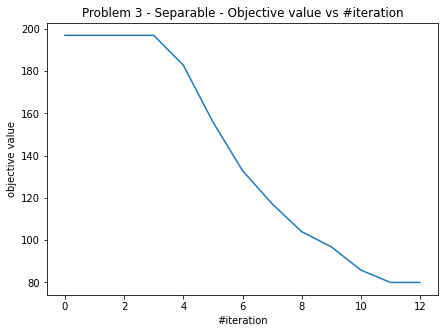

In [13]:
fig = plt.figure(figsize=(7,5))
plt.plot(range(len(prob_vals)), prob_vals)
ax = fig.gca()
plt.title("Problem 3 - Separable - Objective value vs #iteration")
plt.xlabel("#iteration")
plt.ylabel("objective value")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [14]:
u_opt = x1_curr
v_opt = x3_curr

A_opt = np.matmul(A, u_opt)
B_opt = np.matmul(B, v_opt)

gamma = 0.5*(np.linalg.norm(A_opt)**2-np.linalg.norm(B_opt)**2)
normal_vector = A_opt - B_opt
normal_vector = normal_vector

x_lin = np.linspace(-5, 5, 500)
y_lin = (-x_lin*normal_vector[0][0] + gamma)/normal_vector[1][0]

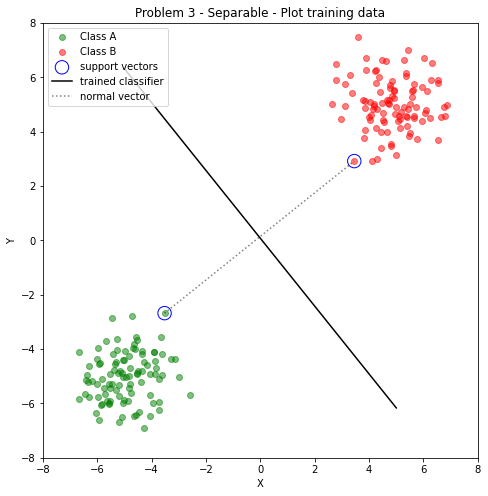

In [15]:
fig = plt.figure(figsize=(8,8))
plt.scatter(A[0,:],A[1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(B[0,:],B[1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 3 - Separable - Plot training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

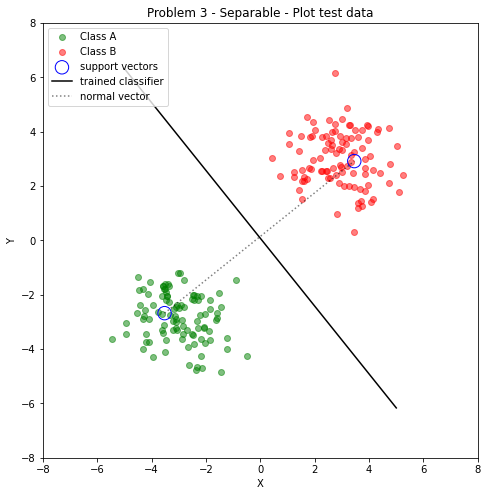

In [16]:
fig = plt.figure(figsize=(8,8))

plt.scatter(test[:,test_label==1][0,:],test[:,test_label==1][1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(test[:,test_label==-1][0,:],test[:,test_label==-1][1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 3 - Separable - Plot test data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8 )
plt.ylim(-8, 8 )
plt.show()

## Problem 3 Overlap

In [17]:
data_train = scipy.io.loadmat("overlap_case/train_overlap.mat")
data_test = scipy.io.loadmat("overlap_case/test_overlap.mat")

In [18]:
A = data_train["A"]
B = data_train["B"]

test = data_test["X_test"]
test_label = data_test["true_labels"].ravel()

In [19]:
np.random.seed(42)

In [20]:
z_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))
m_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))

In [21]:
x1_0 = z_0
x2_0 = np.matmul(A, z_0)
x3_0 = m_0
x4_0 = np.matmul(B, m_0)

x1_prev = x1_0
x2_prev = x2_0
x3_prev = x3_0
x4_prev = x4_0

u1_0 = x1_0 - z_0
u2_0 = x2_0 - np.matmul(A, z_0)
u3_0 = x3_0 - m_0
u4_0 = x4_0 - np.matmul(B, m_0)

u1_prev = u1_0
u2_prev = u2_0
u3_prev = u3_0
u4_prev = u4_0

z_prev = z_0
m_prev = m_0

In [22]:
def calc_gradient_descent(u, v, A, B, iteration=None, alpha=0.1):
    i = 1
    if iteration != None:
        i = iteration
    return u - alpha/(np.sqrt(i))*(2*np.matmul(np.matmul(A.T, A), u) - 2*np.matmul(np.matmul(A.T, B), v))

def calc_projection_x1_x3_reduced_chull(x, n=100, d=0.02, rho=1):
    # optimmization problem
    y = cp.Variable((n, 1))
    ones = np.ones((1,100))
    prob = cp.Problem(cp.Minimize( rho/2*cp.square(cp.norm2(y-x)) ),
                 [cp.matmul(ones, y)==1,
                  y>=0,
                  d*ones.T >= y])
    prob.solve(solver="MOSEK", verbose=False)
    return y.value

def calc_least_square_x2_x4(a, C, z, u, n=2, rho=1):
    return 1/(1+rho/2)*(a+rho/2*np.matmul(C,z)-u)

def calc_least_square_z_m(x1, x2, u1, u2, A, inv, n=100, rho=1):
    return np.matmul(inv, x1+u1+np.matmul(A.T, x2+u2))
    
def calc_least_square_x2_x4_cvx(a, C, z, u, n=2, rho=1):
    y = cp.Variable((n, 1))
    prob = cp.Problem(cp.Minimize(cp.norm(y-a)**2 + rho/2*cp.norm(y-np.matmul(C,z)+u)**2))
    prob.solve(verbose=False)
    return y.value

def calc_least_square_z_m_cvx(x1, x2, u1, u2, A, n=100, rho=1):
    y = cp.Variable((n, 1))
    prob = cp.Problem(cp.Minimize(rho/2*cp.norm(x1-y+u1)**2+rho/2*cp.norm(x2-cp.matmul(A,y)+u2)**2))
    prob.solve(verbose=False)
    return y.value

In [23]:
# ADMM loop
rho = 0.001

min_d = 0.001 # stopping criteria
max_it = 100 # max number of iters
min_it = 5 # min number of iters

prob_vals = []
invA = np.linalg.inv(np.identity(100) + np.matmul(A.T, A))
invB = np.linalg.inv(np.identity(100) + np.matmul(B.T, B))

for i in tqdm(range(max_it)):
    # update x1_curr, x3_curr by projection
    try:
        x1_curr = calc_projection_x1_x3_reduced_chull(x=z_prev-u1_prev, rho=rho)
        x3_curr = calc_projection_x1_x3_reduced_chull(x=m_prev-u3_prev, rho=rho)
    except SolverError:
        print(SolverError)
        break

    # update x2_curr, x4_curr by LS
    # x2_curr = calc_least_square_x2_x4(x4_prev, A, z_prev, u2_prev, rho=rho)
    # x4_curr = calc_least_square_x2_x4(x2_prev, B, m_prev, u2_prev, rho=rho)
    x2_curr = calc_least_square_x2_x4_cvx(x4_prev, A, z_prev, u2_prev, rho=rho)
    x4_curr = calc_least_square_x2_x4_cvx(x2_prev, B, m_prev, u2_prev, rho=rho)

    # update z_curr, m_curr by LS
    # z_curr = calc_least_square_z_m(x1_prev, x2_prev, u1_prev, u2_prev, A, invA, rho=rho)
    # m_curr = calc_least_square_z_m(x3_prev, x4_prev, u3_prev, u4_prev, B, invB, rho=rho)
    z_curr = calc_least_square_z_m_cvx(x1_prev, x2_prev, u1_prev, u2_prev, A, rho=rho)
    m_curr = calc_least_square_z_m_cvx(x3_prev, x4_prev, u3_prev, u4_prev, B, rho=rho)

    # dual update
    u1_curr = u1_prev - x1_curr + z_curr
    u2_curr = u2_prev - x2_curr + np.matmul(A, z_curr)
    u3_curr = u3_prev - x3_curr + m_curr
    u4_curr = u4_prev - x4_curr + np.matmul(B, m_curr)
    
    # save opt values
    prob_vals.append(np.square(np.linalg.norm(np.matmul(A, x1_curr)-np.matmul(B, x3_curr))))
    
    if i >= min_it: 
        if np.square(np.linalg.norm(x1_curr - x1_prev)) <= min_d and np.square(np.linalg.norm(x3_curr - x3_prev)) <= min_d:
            print("stopping criteria satisfied at it {}".format(i))
            break

    # save
    x1_prev = x1_curr
    x2_prev = x2_curr
    x3_prev = x3_curr
    x4_prev = x4_curr

    u1_prev = u1_curr
    u2_prev = u2_curr
    u3_prev = u3_curr
    u4_prev = u4_curr

    z_prev = z_curr
    m_prev = m_curr
    

  6%|████▉                                                                              | 6/100 [00:00<00:12,  7.72it/s]

stopping criteria satisfied at it 6


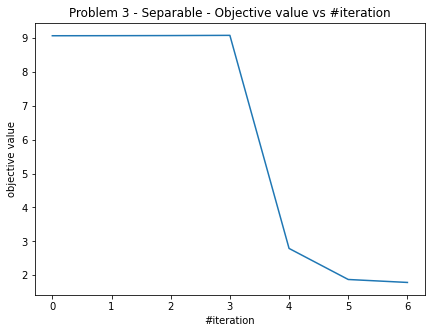

In [24]:
fig = plt.figure(figsize=(7,5))
plt.plot(range(len(prob_vals)), prob_vals)
ax = fig.gca()
plt.title("Problem 3 - Separable - Objective value vs #iteration")
plt.xlabel("#iteration")
plt.ylabel("objective value")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [127]:
u_opt = x1_curr
v_opt = x3_curr

A_opt = np.matmul(A, u_opt)
B_opt = np.matmul(B, v_opt)

gamma = 0.5*(np.linalg.norm(A_opt)**2-np.linalg.norm(B_opt)**2)
normal_vector = A_opt - B_opt
normal_vector = normal_vector

x_lin = np.linspace(-5, 5, 500)
y_lin = (-x_lin*normal_vector[0][0] + gamma)/normal_vector[1][0]

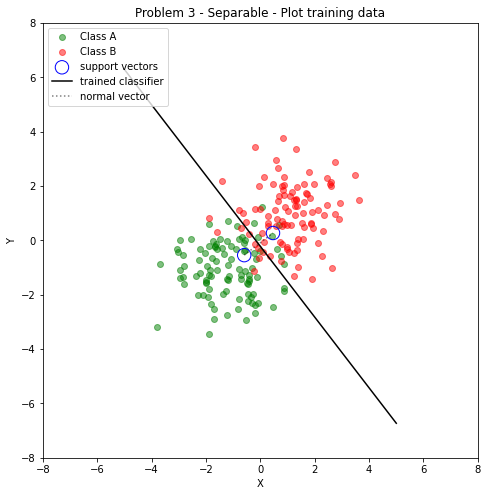

In [128]:
fig = plt.figure(figsize=(8,8))
plt.scatter(A[0,:],A[1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(B[0,:],B[1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 3 - Separable - Plot training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

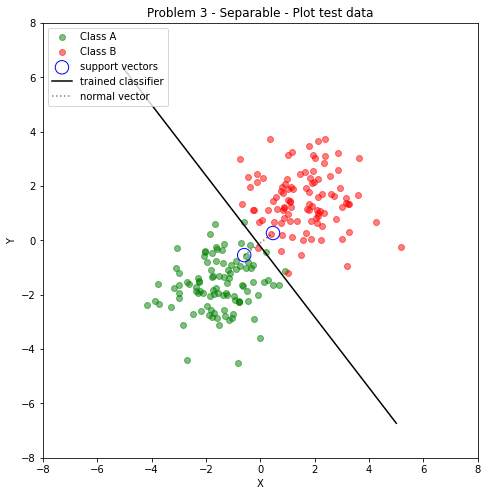

In [129]:
fig = plt.figure(figsize=(8,8))

plt.scatter(test[:,test_label==1][0,:],test[:,test_label==1][1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(test[:,test_label==-1][0,:],test[:,test_label==-1][1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 3 - Separable - Plot test data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8 )
plt.ylim(-8, 8 )
plt.show()